# Locality Sensitive Hashing

Veamos como se comporta una búsqueda de los 10 vecinos más cercanos por árboles binarios (`KDTree`) y por una búsqueda secuencial ante datos de distintos tamaños de datos

9% 18% 28% 37% 46% 56% 65% 75% 84% 93%

(0, 0.46036163965861004)

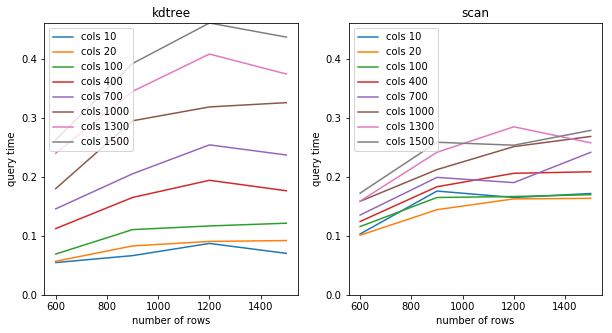

In [1]:
import numpy as np
from scipy.spatial import KDTree
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

def euclidean_distance(a,b):
    return np.sqrt( np.sum((a-b)**2 ) )

def create_data(n_rows, n_cols):
    return (np.random.random((n_rows, n_cols))-0.5)*1000

def get_nn_by_scan(data, q, k=10):
    r = []
    kmax_idx = None
    for d in data:
        distance = euclidean_distance(d,q)
        if len(r)<k:
            r.append(distance)
            kmax_idx = np.argmax(r)
        elif distance<r[kmax_idx]:
            r[kmax_idx]=distance
            kmax_idx = np.argmax(r)
    return r
        
max_rows = 1000
max_cols = 4000
data = create_data(max_rows, max_cols)

rowset = [1000,3000,5000,7000,9000,11000,13000,15000,17000]
colset = [100,200,300,400,600,800,1000]

rowset = [600,900,1200,1500]
colset = [10,20,100,400,700,1000,1300,1500]

times_per_rows = { "kdtree": {}, "scan": {} }
times_per_cols = { "kdtree": {}, "scan": {} }



for row in rowset:
    times_per_rows["kdtree"][row] = []
    times_per_rows["scan"][row] = []
    
for col in colset:
    times_per_cols["kdtree"][col] = []
    times_per_cols["scan"][col] = []

N=10
total,c = len(rowset)*len(colset),1

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
maxt = -np.inf
for col in colset:
    tlist_kdtree = []
    tlist_scan   = []
    for row in rowset:                    
        if c%(total/10)==0:
            print "%d"%(c*100./total)+"%",
        c+=1
        d = data [:row,:col]
        kdtree = KDTree(d)
        q = create_data(1,col)[0]
        ttk,tts = [], []
        for i in range(3):
            ts = time(); kdtree_nn = [kdtree.query(q,10)[0] for i in range(N)][0]; tkdtree = time()-ts
            ts = time(); scan_nn   = [get_nn_by_scan(d,q,10) for i in range(N)][0]; tscan = time()-ts
            ttk.append(tkdtree)
            tts.append(tscan)
        tlist_kdtree.append(np.mean(ttk))
        tlist_scan.append(np.mean(tts))
        m = np.max(tlist_kdtree+tlist_scan)
        maxt = m if maxt < m else maxt
#        print "rows %5d cols %5d check kdtree=scan %.3f"%(row, col, np.sum(kdtree_nn)-np.sum(scan_nn))
    ax1.plot(rowset, tlist_kdtree, label="cols %d"%col)
    ax2.plot(rowset, tlist_scan, label="cols %d"%col)

ax1.set_title("kdtree")
ax1.set_xlabel("number of rows")
ax1.set_ylabel("query time")
ax1.set_ylim(0,maxt)
ax1.legend()

ax2.set_title("scan")
ax2.set_xlabel("number of rows")
ax2.set_ylabel("query time")
ax2.legend()
ax2.set_ylim(0,maxt)


## Hashing basado en bits con distancia de Hamming

Tenemos cadenas de 4 bits. Por ejemplo $x = [0,1,1,0]$ e $y = [0,1,1,1]$ serían dos de esas cadenas. La **distancia Hamming**, $d_h$, es una medida de simulitud entre dos cadenas de bits y simplemente cuenta el número de posiciones en las cuales las dos cadenas difieren [[wikipedia](https://www.wikiwand.com/en/Hamming_distance)]. En nuestro caso $d_h(x,y)=1$.

Denotamos con $x_i$ al bit $i$ de la cadena $x$. Así, $x_0=0$, $x_1=1$, etc. para el ejemplo anterior. Nos planteamos ahora la siguiente pregunta:

> Si sabemos la distancia entre dos cadenas de cuatro bits es menor o igual que uno,
> ¿Cuál es la probabilidad de que  $x_1=y_1$, es decir, de que $x$ e $y$ coinciden en el bit número 1? 

Estamos preguntando por la siguiente probabilidad

$$P(  x_1=y_1 \; | \; d_h(x,y) \le 1 )$$

Obtenemos dicha probabilidad con el siguiente razonamiento. Dadas dos cadenas de 4 bits, denotamos por $c(x,y)$ a la cadena de bits que señala qué bits de $x$ e $y$ son iguales. En el ejemplo anterior $c(x,y)=[1,1,1,0]$ ya que solo difieren en el último bit. Si $d(x,y) \le 1$ entonces $c(x,y) = [1,1,1,1]$ (distancia 0), o $c(x,y)$ contiene un único cero, es decir, es una de las siguientes $[0,1,1,1], [1,0,1,1], [1,1,0,1], [1,1,1,0]$. De todas esos cinco posibles $c(x,y)$ hay cuatro en los que el primer bit es 1, por tanto $P_1 = P(  x_1=y_1 \; | \; d_h(x,y) \le 1 ) = 4/5 = 0.8$. Si te fijas, da igual que el bit de coincidencia sea el 1 como en este caso, o cualquier otro.

Consideremos ahora la siguiente pregunta:

> Si sabemos que la distancia entre dos cadenas de cuatro bits es mayor o igual que tres
> ¿Cuál es la probabilidad de que $x$ e $y$ coincidan en el primer bit?

Con un razonamiento parecido, estamos considerando $c(x,y)$ que tenga tres o cuatro ceros, es decir, $[0,0,0,0]$, $[1,0,0,0]$,$[0,1,0,0]$,$[0,0,1,0]$,$[0,0,0,1]$. De todas estas cadenas tan sólo una tiene el primer bit a 1 (indicando que $x$ e $y$ coinciden en el primer bit). Por tanto $P(  x_1=y_1 \; | \; d_h(x,y) \ge 3 ) = 0.2$

Con esto, dividimos nuestro dataset de cadenas de cuatro bits (16 cadenas si el dataset contiene todas las posibles cadenas) en dos _buckets_ según el valor del primer bit de cada cadena. Quedaría así:

    bucket-0: 0000 0001 0010 0011 0100 0101 0110 0111
    bucket-1: 1000 1001 1010 1011 1100 1101 1110 1111

ahora nos dan un punto de query, p.ej el `0101` y queremos encontrar vecinos _cercanos_ que estén a una distancia Hamming de uno o menos. Para restringir la búsqueda inspeccionamos sólo el bucket que le correspondería al punto de query, es decir, el bucket-0. El hecho de que $P_1 = 0.8$ nos dice que el 80% de los puntos _cercanos_ van a estar en el bucket que estamos inspeccionando. El hecho de que $P_2 = 0.2$ nos dice que sólo el 20% de  los puntos que están a distance 3 o más estarán en ese bucket. O sea, que inspeccionaremos mayormente puntos que están a la distancia que queremos.

Si nuestro dataset es muy grande podemos usar más bits para la función de hash. Si usamos 10 bits tendremos 1024 buckets. Observa que:

- Si $P_1$ es muy grande casi todos los puntos cercanos al query estarán en el bucket asignado al query
- Si $P_2$ es muy grande habrá también muchos puntos no cercanos en el mismo bucket.

Formalmente, dada una métrica $d$ buscamos una función de hash $h$ que (ver [wikipedia](https://www.wikiwand.com/en/Locality-sensitive_hashing)):

- si $d(x,y) \le R$, entonces $h(x)=h(y)$ (i.e.,$x$ y $y$ colisionan) con probabilidad mayor que $P_1$,
- si $d(x,y) \ge C$, entonces $h(x)=h(y)$ con probabilidad menor que $P_2$.

con $C>R$, en donde podamos garantizar que $P_1$ sea grande y $P_2$ pequeño.

Esto conforma una familia LSH denotada por la tupla $(R,C, P_1, P_2)$

juega con los parámetros del siguiente código que muestrea aleatoriamente cadenas de $l$ bits y estima $P_1$ y $P_2$


In [2]:
import numpy as np

l = 4 # chain length
R = 1  # distance to neighbour
C = 3  # cR distance to far
n = 1  # nb hash bits
n_funcs = 1 # number of functions
    
def get_freqs_P1_P2 (chain_length, n, R, C, N=10000):

    assert n<=chain_length
    tot_P1, tot_P2, P1, P2 = 0., 0., 0., 0.
    hash_bits = np.random.permutation(chain_length)[:n] 
    
    for i in range(N):
        x      = np.random.randint(2, size=chain_length)
        eqbits = np.sum(x[hash_bits])
        d      = chain_length-np.sum(x)        
        
        if d <= R:
            tot_P1 += 1
            if eqbits==n:
                P1 += 1
        
        elif d >= C:
            tot_P2 += 1
            if eqbits==n:
                P2 += 1
    return (P1/tot_P1 if tot_P1!=0 else 0, 
            P2/tot_P2 if tot_P2!=0 else 0) 

p1,p2 = get_freqs_P1_P2 (l,n,R,C)

print "cadenas de longitud", l
print "numero de bits hash", n
print "number of functions", n_funcs

print "P(h|d<=%2d"%R+") = %.3f"%p1,   ", teórico > %.3f"%(1-R*1./l)
print "P(h|d>=%2d"%C+") = %.3f"%p2, ", teórico < %.3f"%(1-C*1./l)


cadenas de longitud 4
numero de bits hash 1
number of functions 1
P(h|d<= 1) = 0.812 , teórico > 0.750
P(h|d>= 3) = 0.187 , teórico < 0.250


Podemos ver cómo  cambian $P_1$ y $P_2$ para distintos valores de $n$, $R$ y $C$ y así calibrar nuestro algoritmo. Por ejemplo, si tenemos cadenas de logitud 10 y usamos un hash de dos bits, ¿qué valor de $P_1$ y $P_2$ tenemos para $R=1$ y $C=3$? ¿Qué interpretación le das?

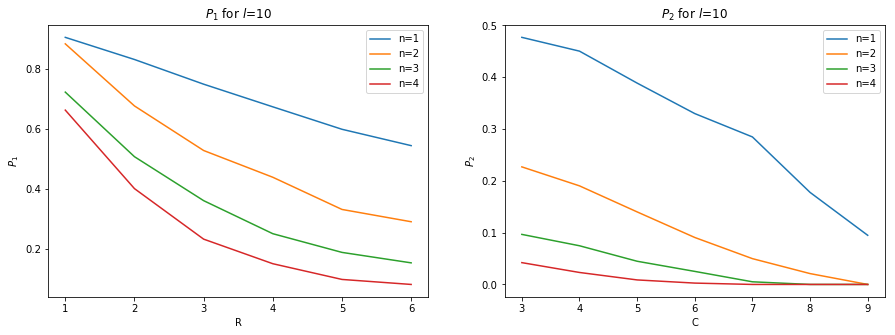

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
chain_length=10
n_list = [1,2,3,4]
R_list = [1,2,3,4,5,6]
C_list = chain_length-np.array([1,2,3,4,5,6,7])

fig = plt.figure(figsize=(15,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

for n in n_list:
    p1 = [get_freqs_P1_P2(chain_length, n, R, 0)[0] for R in R_list]
    p2 = [get_freqs_P1_P2(chain_length, n, 0, C)[1] for C in C_list]
    ax1.plot(R_list, p1, label="n="+str(n))
    ax2.plot(C_list, p2, label="n="+str(n))
        
ax1.set_xlabel("R")
ax1.set_ylabel("$P_1$")
ax1.legend()
ax1.set_title("$P_1$ for $l$=%d"%chain_length)

ax2.set_xlabel("C")
ax2.set_ylabel("$P_2$")
ax2.legend()
ax2.set_title("$P_2$ for $l$=%d"%chain_length)


## Amplificación de familias LSH

es probable que para una familia $(R,C,P_1, P_2)$ dada no tengamos valores muy útiles de $P_1$ y $P_2$. Por ejemplo, si $P_1=0.6$ y $P_2=0.45$, para cualquier bucket los datos cercanos y lejanos van a estar muy mezclados y, además, vamos a perder muchos valores cercanos (un 40%, o sea $1-P_1$).

Podemos combinar distintas funciones de una misma familia LSH de dos maneras. Por ejemplo si usamos dos funciones de hash de 2 bits, la primera usando los dos primeros bits de las cadenas y la segunda usando los dos últimos bits. Dado un punto de query y varias funciones de hash, podemos considerar los puntos que:

- bien están en TODOS los buckets de las funciones de hash, es decir, en el ejemplo anterior que tanto los dos primeros como los dos últimos bits son iguales.

- bien están en AL MENOS un bucket de las funcioens de hash, es decir, que bien tienen los dos primeros bits iguales, bien tienen los dos últimos bits iguales.

El primer caso es una combinación **AND** de funciones de hash, y el segundo caso es una combinación **OR**.

Ahora, dada una familia LSH $(R,C,P_1, P_2)$, podemos crear una nueva familia $(R,C,P'_1, P'_2)$ combinando $t$ funciones de la familia original. Entonces,

- si realizamos una combinación **AND** de $t$ funciones, tendremos $P'_1 = (P_1)^t$ y $P'_2 = (P_2)^t$
- si realizamos una combinación **OR** de $t$ funciones, tendremos $P'_1 = 1-(1-P_1)^t$ y $P_2 = 1-(1-P_2)^t$

Dados valores cualquiera de $P_1$ y $P_2$, lo que nos interesa es que, al combinar dos funciones la distancia entre $P_1$ y $P_2$ aumente ya que así conseguiremos más separabilidad entre los puntos que son disimilares. Es decir, 

- en el caso "AND", queremos que $P_1-P_2 < (P_1)^2 - (P_2)^2 \Rightarrow P_1-P_2 - (P_1)^2 + (P_2)^2 < 0 $
- en el caso "OR", $P_1 - P_2 < (1 - (1-P_1)^2) - (1-(1-P_2)^2) \Rightarrow P_1 - P_2 + (1-P_1)^2 - (1-P_2)^2 < 0$

Las gráficas siguientes representan (en blanco) las combinaciones de $P_1$ y $P_2$ para las que se cumplen las desigualdades anteriores, en el caso de combinaciones con "AND" o con "OR".

Observa que, para cualquier par de valores $P_1$ y $P_2$, **siempre podemos aumentar la distancia** entre ellos escogiendo una de las dos operaciones.

([], <a list of 0 Text yticklabel objects>)

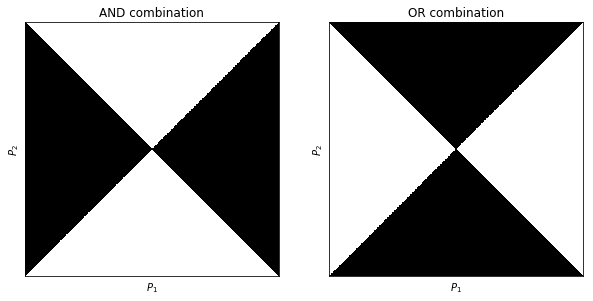

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


xs = np.linspace(0, 1, 400)
ys = np.linspace(0, 1, 400)
P1,P2 = np.meshgrid(xs, xs)
fig=plt.figure(figsize=(10,7))

fig.add_subplot(121)
Z = P1 - P2 - P1**2 + P2**2
plt.imshow(Z>0, cmap = plt.cm.Greys_r)
plt.xlabel("$P_1$"), plt.ylabel("$P_2$"); plt.xticks([]); plt.yticks([])
plt.title("AND combination")

fig.add_subplot(122)
Z = P1 - P2 + (1-P1)**2 - (1-P2)**2
plt.imshow(Z>0, cmap = plt.cm.Greys_r)
plt.title("OR combination")
plt.xlabel("$P_1$"), plt.ylabel("$P_2$"); plt.xticks([]); plt.yticks([])


### LSH Discretizado para distancia euclidiana

Proyectamos los puntos de datos sobre planos discretizados con un ancho de _bin_ $w$

Para una sóla proyección esto resulta en una familia LSH que aproxima la distancia euclidiana  $\mathcal{F} (w/2, 2w, 1/2, 1/3)$

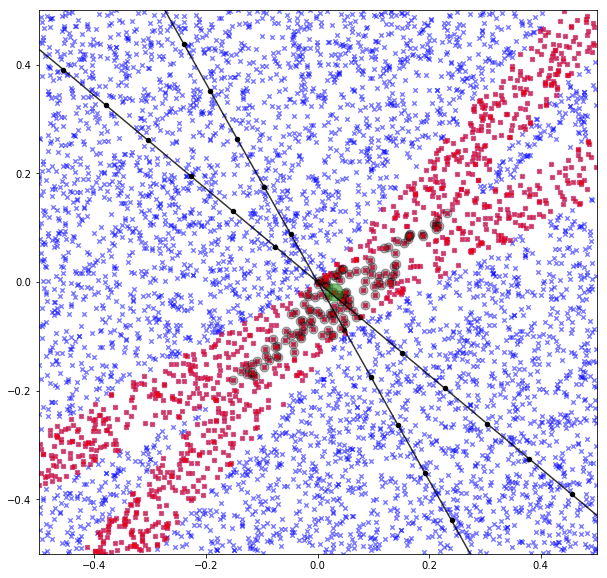

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n_samples=5000
d = np.random.random(size=(n_samples,2))-0.5
q, d = d[0], d[1:,:]
ax = plt.figure(figsize=(10,10)).add_subplot(111)

plt.scatter(d[:,0],d[:,1], s=20, marker="x", color="blue", alpha=0.5)    

def gb(p, d):
    dp = d.dot(p)*p/np.linalg.norm(p)**2
    return int((1 if dp[0]>=0 else -1)*(np.sqrt(np.sum(dp**2))/bin_width+1))
        
def create_projections(n_projections):
    return np.random.random(size=(n_projections,2))-0.5

def plot_projection_with_bins(p, bin_width):
    plt.plot([p[0],-p[0]], [p[1],-p[1]], color="black", alpha=0.8)
    slope = p[1]/p[0]
    x, dx = 0, bin_width/np.sqrt(1+slope**2)
    while x<0.6:
        plt.scatter(x, x*slope, s=20, color="black", marker="o")
        plt.scatter(-x, -x*slope, s=20, color="black", marker="o")
        x += dx
        if dx<1e-3:
            break
                
bin_width, n_projections = 0.1, 2
projections   = create_projections(n_projections)
for i in range(len(projections)):
    p = projections[i]/np.linalg.norm(projections[i])
    plot_projection_with_bins(p, bin_width)

for dpoint in d:
    r = []
    for p in projections:
        r.append(1 if gb(p,dpoint)==gb(p,q) else 0)
    if np.sum(r)==n_projections:
        plt.scatter(dpoint[0],dpoint[1], s=80, marker="o", color="black", alpha=.3)                    
    if np.sum(r)>0:
        plt.scatter(dpoint[0],dpoint[1], s=20, marker="o", color="red", alpha=.5)    

plt.scatter(q[0],q[1], s=20, marker="x", color="red", alpha=0.8)    
plt.scatter(q[0],q[1], s=300, marker="o", color="green", alpha=0.5)        
  
plt.ylim(-.5,.5); plt.xlim(-.5,.5);


### Refs

http://infolab.stanford.edu/~ullman/mining/2009/similarity3.pdf